In [1]:
#импортируем нужные либы
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# для преобразования из строки в список
import ast

In [2]:
# Подключение к нужному хосту кликхауса
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
#пишем запрос, и получаем данные о кол-во строк
query = """
SELECT count(*)
FROM ldn_listings
"""
# Чтобы посмотреть одно значение функции
ph.execute(query, connection=connection_default)


b'85207\n'

In [4]:
# Выгрузите из таблицы данные о цене в зависимости от типа жилья. 

query = """ 
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price
FROM ldn_listings
ORDER BY id ASC
LIMIT 1000
    
"""

df_room_type = ph.read_clickhouse(query, connection=connection_default)
df_room_type

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [5]:
# Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.
df_room_type.groupby('room_type').quantile(q=0.75).query('room_type == "Private room"')

,price
room_type,
Private room,70.0


In [6]:
# К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
# В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.
query_two = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price,
    toFloat32OrZero(review_scores_rating) AS review_scores_rating
FROM ldn_listings
WHERE review_scores_rating != 0
ORDER BY id ASC
LIMIT 1000

"""
df_rew_scor = ph.read_clickhouse(query_two, connection=connection_default)
df_rew_scor

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [7]:
# Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки 
# в зависимости от типа жилья.
df_group = df_rew_scor.groupby('room_type', as_index=False) \
    .agg({'review_scores_rating': 'mean', 'price': 'mean'})

<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

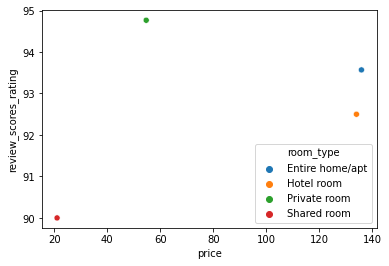

In [8]:
sns.scatterplot(x='price', y='review_scores_rating', data=df_group, hue='room_type')

In [9]:
query_three = """
SELECT 
    DISTINCT(host_id) AS host_id,
    host_verifications 
FROM ldn_listings
WHERE experiences_offered != 'none'

"""
df_verif = ph.read_clickhouse(query_three, connection=connection_default)
df_verif

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [10]:
# Разделяем строку на список
df_verif.host_verifications = df_verif.host_verifications.apply(lambda s: ast.literal_eval(s))

In [11]:
# Разрезаем список на отдельные части по каждому пользователю и считаем кол-во
df_verif.explode('host_verifications').host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [12]:
# Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 
# Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. 
# Новый столбец назовите experiences_count.
# Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк.

query_four = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    count(id) AS experiences_count 
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY 
    neighbourhood_cleansed, 
    experiences_offered 
ORDER BY experiences_count DESC
LIMIT 100

"""

df_count_exper = ph.read_clickhouse(query_four, connection=connection_default)
df_count_exper

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [13]:
# Затем преобразуйте данные с помощью pivot, поместив в индексы название района, 
# столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. 

pivot_df = df_count_exper.pivot_table(index='neighbourhood_cleansed', columns='experiences_offered', 
                                    values='experiences_count', aggfunc='sum')

<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

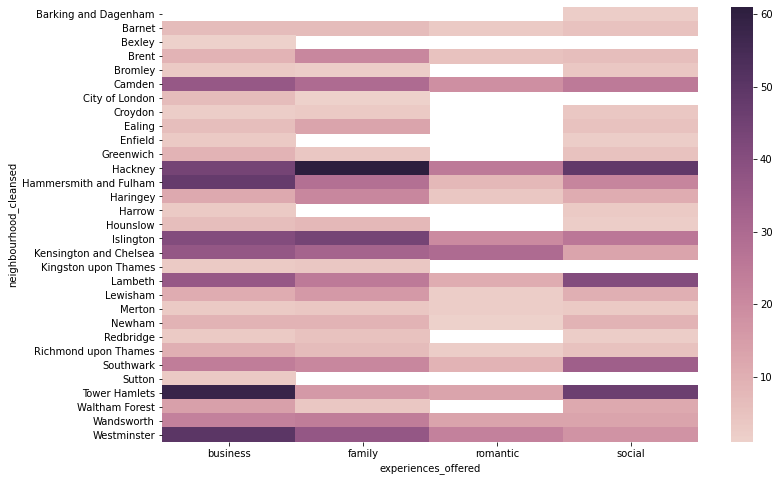

In [14]:
# Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

plt.figure(figsize=(12,8))
sns.heatmap(data=pivot_df, cmap=sns.cubehelix_palette(as_cmap=True))

In [15]:
# Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.
query_5 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price
FROM ldn_listings
WHERE experiences_offered != 'none'

"""
df_log = ph.read_clickhouse(query_5, connection=connection_default)
df_log

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [16]:
# Далее постройте два графика, используя distplot из библиотеки seaborn:

df_log['price_log'] = np.log(df_log.price)

C:\Users\1233-\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price'>

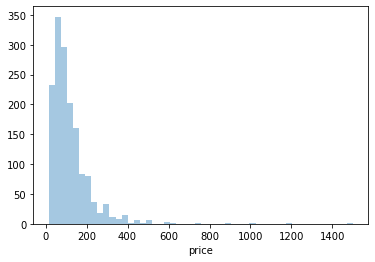

In [17]:
# На первом отобразите исходные распределения цен для каждого типа жилья
sns.distplot(df_log.price, kde=False)

<AxesSubplot:xlabel='price_log'>

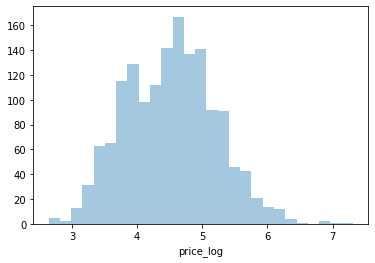

In [18]:
# На втором – логарифмированные значения (np.log())
sns.distplot(df_log.price_log, kde=False)

In [19]:
# Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.
query_6 = """

SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price,
    first_review 
FROM ldn_listings
WHERE first_review >'2010-01-01'

LIMIT 1000

"""
df_date = ph.read_clickhouse(query_6, connection=connection_default)
df_date

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [20]:
df_date.dtypes

room_type        object
price           float32
first_review     object
dtype: object

In [21]:
df_date['first_review'] = pd.to_datetime(df_date['first_review'])

In [22]:
df_date['year'] = df_date.first_review.dt.year

In [23]:
# Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) 
# в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). 
# Датафрейм должен быть отсортирован по годам.
df44 = df_date.groupby(['room_type', 'year'], as_index=False) \
    .agg({'price': 'mean'})

<AxesSubplot:xlabel='year', ylabel='price'>

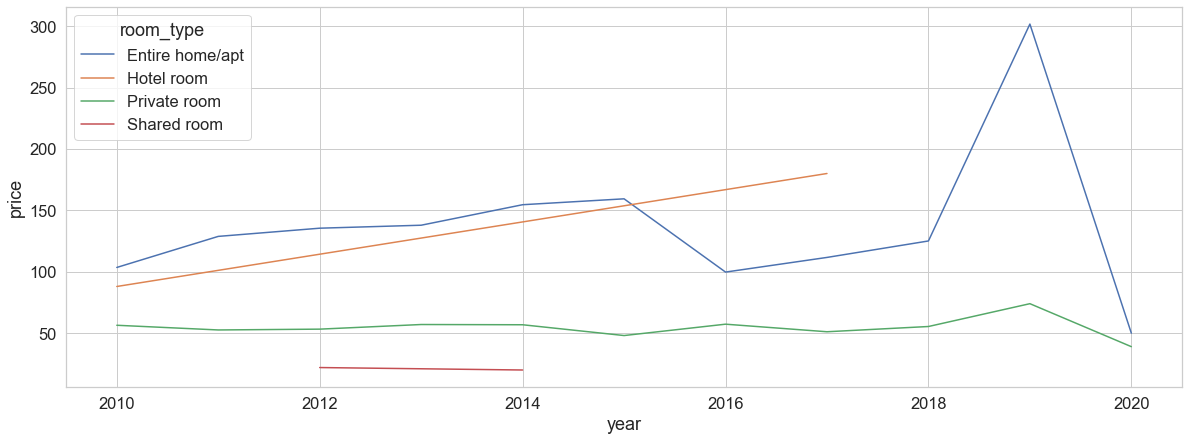

In [24]:
# Делаем настройку графиков
sns.set(
    font_scale = 1.5, # размер шрифта
    style="whitegrid", # Общий вид графиков(стиль)
    rc={'figure.figsize':(20,7)} # размер графиков
)
sns.lineplot(x='year', y='price', data=df44, hue='room_type')